In [274]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [275]:
'''
Reading the MNIST/USPS Handwritten Digits Dataset
'''


def readData(fname='ZipDigits.train'):
    '''
    Input:
        fname: name of file containing N examples, each with d attributes
    Output:
        X: N x d+1 numpy array
        y: N x 1 numpy array
    '''
    with open(fname) as f:
        X = []
        y = []
        rlines = f.readlines()
        for line in rlines:
            row = line.rstrip().split(' ')
            yval = int(float(row[0]))
            y.append(yval)
            xvals = [float(pixel) for pixel in row[1:]]
            X.append(xvals)
        X = np.array(X)
        y = np.array(y)
        y = y.reshape((y.shape[0], 1))
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        return X, y

In [276]:
'''
Read training and test datasets
'''
if True:
    Xdigitstrain, ydigitstrain = readData('ZipDigits.train')

    Ndigitstrain, pixels = Xdigitstrain.shape

    assert(Ndigitstrain == ydigitstrain.shape[0])

X shape: (7291, 256)
y shape: (7291, 1)


In [277]:
if True:
    Xdigitstest, ydigitstest = readData('ZipDigits.test')

    Ndigitstest, pixels = Xdigitstest.shape

    assert(Ndigitstest == ydigitstest.shape[0])

X shape: (2007, 256)
y shape: (2007, 1)


In [278]:
'''
Computing Features
'''


def computeIntensity(X):
    '''
    Compute the average intensity feature
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        intensities: a 2 dimensional N x 1 numpy array
                     each row consists of a single value representing the
                     average pixel intesity of the corresponding image
                     See LFD Example 3.1
    '''
    print('computing intensity feature')
    N, d = X.shape
    print(f'Input shape {N}, {d}')
    intensities = np.matmul(X, np.ones((d, 1)))/d
    print(f'Output shape {intensities.shape}')
    return intensities


def computeSymmetry(X):
    '''
    Compute the symmetry feature
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        symmetries: a 2 dimensional N x 1 numpy array
                     each row consists of a single value representing the
                     "horizontal" symmetry of the 16 x 16 image about the vertical axis
                     See LFD Example 3.1
    '''
    print('computing symmetry feature')
    N, d = X.shape
    print(f'Input shape {N}, {d}')
    Ximgs = [X[n, :].reshape((16, 16)) for n in range(N)]
    Ximgs_flipped = [np.flip(Ximgs[n], axis=1) for n in range(N)]
    symmetries = [np.sum(np.abs((Ximgs[n] - Ximgs_flipped[n])
                                ).reshape(256, ))/d for n in range(N)]
    symmetries = -np.array(symmetries)
    symmetries = symmetries.reshape(N, 1)
    print(f'Output shape {symmetries.shape}')
    return symmetries

In [279]:
'''
Computing the augmented feature matrix
'''


def computeAugmentedXWithFeatures(X):
    '''
    Compute the augmented feature matrix
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        Xaug: a 2 dimensional N x 3 numpy array
              the augmented feature matrix
              the i-th row corresponds to the i-th row of X (and image represented by it)
              the 0-th column is the column of 1s
              the 1-st column is the column of average intensities
              the 2-nd column is the column of horizontal symmetries
    '''
    N, d = X.shape
    intensity = computeIntensity(X)
    symmetry = computeSymmetry(X)
    dummy = np.ones((N, 1))
    Xaug = np.concatenate((dummy, intensity, symmetry), axis=1)
    print(f'Shape of augmented feature matrix: {Xaug.shape}')
    return Xaug

In [280]:
'''
Compute the augmented matrix with features
'''

if True:
    print('Computing augmented training feature matrix')

    Xaugtrain = computeAugmentedXWithFeatures(Xdigitstrain)

    Naugtrain, d = Xaugtrain.shape

    print('Computing augmented test feature matrix')

    Xaugtest = computeAugmentedXWithFeatures(Xdigitstest)

    Naugtest, d = Xaugtest.shape

Computing augmented training feature matrix
computing intensity feature
Input shape 7291, 256
Output shape (7291, 1)
computing symmetry feature
Input shape 7291, 256
Output shape (7291, 1)
Shape of augmented feature matrix: (7291, 3)
Computing augmented test feature matrix
computing intensity feature
Input shape 2007, 256
Output shape (2007, 1)
computing symmetry feature
Input shape 2007, 256
Output shape (2007, 1)
Shape of augmented feature matrix: (2007, 3)


In [281]:
Xaug = np.concatenate((Xaugtrain, Xaugtest), axis=0)
Naug, d = Xaug.shape
ycombined = np.concatenate((ydigitstrain, ydigitstest), axis=0)

assert(Xaug.shape[0] == Ndigitstrain + Ndigitstest)
assert(ycombined.shape[0] == Ndigitstrain + Ndigitstest)

print(f'Xaug shape {Xaug.shape}, ycombined shape {ycombined.shape}')

Xaug shape (9298, 3), ycombined shape (9298, 1)


In [282]:
def normalize(X, a=-1, b=1):
    N, d = X.shape
    Xnorm = np.ones((N, d))
    for col in range(1, d):
        Xcol = X[:, col]
        maxval = np.max(Xcol)
        minval = np.min(Xcol)
        xvaldiff = maxval - minval
        Xcolnorm = a + ((Xcol - minval) / xvaldiff)*(b-a)
        Xnorm[:, col] = Xcolnorm
    return Xnorm

In [283]:
Xnorm = normalize(Xaug)
N, d = Xnorm.shape

assert(Xnorm.shape == Xaug.shape)
assert(np.all(Xnorm[:, 0] == np.ones((N, 1)) ))

In [285]:
for n in range(N):
    if ycombined[n, 0] == 1:
        ycombined[n, 0] = 1
    else:
        ycombined[n, 0] = -1

In [286]:
def splitDataSelectKRandomly(X, y, K):
    '''
    Partitions the input dataset with N data points given by X and y into two parts,
    one with K of the data points selected uniformly at random, and
    the other with the remaining N-K data points
    Input:
        X: a 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
        y: a 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        K: an integer; number of data points to select
    Output:
        Xselected: a 2 dimensional K x d numpy array, K data points selected from X uniformly at random
        yselected: a 2 dimensional K x 1 numpy array, the labels from the input y corresponding to the examples selected in Xselected
        Xremaining: a 2 dimensional N-K x d numpy array
        yremaining: a 2 dimensional N-K x 1 numpy array
    '''
    N, d = X.shape
    selected_indices = np.random.choice(N, K, replace=False)
    remaining_indices = np.setdiff1d(np.arange(N), selected_indices)
    Xselected = X[selected_indices, :]
    yselected = y[selected_indices, :]
    Xremaining = X[remaining_indices, :]
    yremaining = y[remaining_indices, :]
    return Xselected, yselected, Xremaining, yremaining

In [287]:
X, y, Xtest, ytest = splitDataSelectKRandomly(Xnorm, ycombined, 300)

print(f'Xnorm shape {Xnorm.shape} ycombined shape {ycombined.shape}\n\
X shape {X.shape} y shape {y.shape}\n\
Xtest shape {Xtest.shape}, ytest shape {ytest.shape}')

Xnorm shape (9298, 3) ycombined shape (9298, 1)
X shape (300, 3) y shape (300, 1)
Xtest shape (8998, 3), ytest shape (8998, 1)


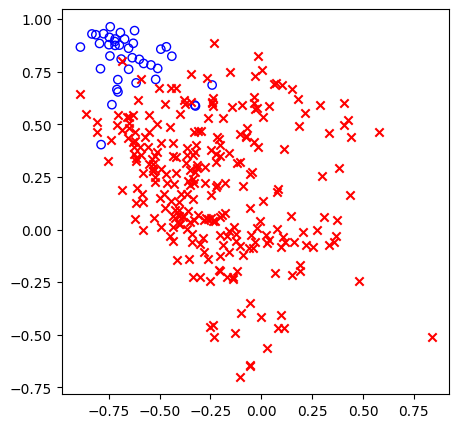

In [288]:
fig, axs = plt.subplots(figsize=(5, 5))
plus1s = np.where(y == 1)[0]
minus1s = np.where(y == -1)[0]
Xplus1s = X[plus1s, :]
Xminus1s = X[minus1s, :]
axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
            color='blue', facecolors='none', label='1')
axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
            marker='x', color='red', label='Not 1')

In [289]:
def LegendrePolynomials(x, Q):
    '''
    Compute the values of Legendre polynomials with degrees 0, 1, 2, ..., Q at the input x
    Input:
        x: a real number
        Q: a positive integer
    Output:
        L: a list with Q+1 entries,
           where for any k=0, 1, ..., Q,
           L[k] is the value of the k-th order Legendre polynomial at x
    '''
    L = [1, x]
    # TODO: Complete the implementation
    for k in range(2, Q + 1):
        L.append(((2 * k - 1) * x * L[k - 1] - (k - 1) * L[k - 2]) / k)
    return L

In [290]:
from itertools import permutations, combinations_with_replacement
def polynomialTransformLegendre(X, Q):
    '''
    Compute the Legendre Polynomial Feature Transform
    See LFD Example 3.3
    Input:
        X: A 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
        Q: The desired degree of polynomial
    Output:
        Z: A 2 dimensional N x d_tilde numpy array
           The n-th row Z[n, :] contains features corresponding to the Q-th order polynomial transform of X[n, :]
           Z[n, 0] = 1
           Z[n, 1], ..., Z[d_tilde] contain the transformed features
    Warning and TODO: This is a hack! Can we do better?
    '''
    N, d = X.shape
    if np.all(X[:, 0] == np.ones((N, 1))):
        X = X[:, 1:]
    N, d = X.shape

    '''
    Setup
    '''
    degrees = range(Q+1)
    perms = permutations(range(d))
    perms = list(perms)
    combs = combinations_with_replacement(degrees, d)
    combs = list(combs)
    '''
    List feature names
    '''
    terms = []
    ftnames = []
    for c in combs:
        if np.sum(c) == 0:
            continue
        if np.sum(c) > Q:
            continue
        for p in perms:
            ftname = '*'.join(sorted([f'L_{c[col]}(x[{p[col]}])' for col in range(d)]))
            if ftname in ftnames:
                continue
            terms.append((c, p))
            ftnames.append(ftname)
    '''
    Compute features
    '''
    Z = []
    for n in range(N):
        row = [1]
        x = X[n, :]
        z = []
        Ls = [LegendrePolynomials(x[col], Q) for col in range(d)]
        for t in terms:
            (c, p) = t
            v = np.prod([Ls[p[i]][c[i]] for i in range(d)])
            z.append(v)
        z = [1] + z
        Z.append(z)
    Z = np.array(Z)
    return Z

In [291]:
Q = 10

Z = polynomialTransformLegendre(X, Q)
print(f'Z shape {Z.shape}')
Ztest = polynomialTransformLegendre(Xtest, Q)
print(f'Ztest shape {Ztest.shape}')

Z shape (300, 66)
Ztest shape (8998, 66)


In [292]:
def predictClassLinear(w, X):
    '''
    Input:
        w: a 2D (d+1) x 1 numpy array of weights for a linear hypothesis
        X: a 2D N x (d+1) numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
    Output:
        yhat: an N x 1 2 dimensional numpy array orf predictions
    '''
    yhat = np.sign(np.matmul(X, w))
    return yhat

In [293]:
from matplotlib.colors import ListedColormap
'''
Updated plotting routine to use Legendre Polynomial transform instead
'''
def plotNonLinearSeparator(w, X, y, Q=2, title=''):
    '''
    Plot the "effective" decision boundary and half spaces
    determined by a non-linear separator in 2D space
    which is picked from a linear model in higher dimensional space
    using the polynomial transform
    Input:
        w: a d x 1 2 dimensional numpy array of weights for a linear hypothesis
        X: a 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
        y: a 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        Q: The desired degree of polynomial
        title: a string
    Output:
        No output
    '''
    fig, axs = plt.subplots(figsize=(10, 10))
    '''
    Plot separator
    '''
    pltx1s = np.linspace(-1, 1, 100)
    pltx2s = np.linspace(-1, 1, 100)
    pltX = np.array([[1, x, y] for x in pltx1s for y in pltx2s])
    # a function that performs the polynomial transform
    pltZ = polynomialTransformLegendre(pltX, Q=Q)
    pltyhat = predictClassLinear(w, pltZ)
    pltx1s = pltX[:, 1].reshape((pltX.shape[0], 1))
    pltx2s = pltX[:, 2].reshape((pltX.shape[0], 1))
    cmap = ListedColormap(['lightcoral', 'lightskyblue'])
    axs.scatter(pltx1s, pltx2s, c=pltyhat, cmap=cmap)
    '''
    Plot data points
    '''
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='Not 1')
    '''
    Finishing touches
    '''
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)
    axs.set_xlabel('intensity')
    axs.set_ylabel('symmetry')
    axs.set_title(title)
    axs.legend()
    plt.show()

In [294]:
import numpy as np

def squaredError(w, X, y):
    '''
    point-wise sum of squared error (for regression)
    Input:
        w: a d x 1 2 dimensional numpy array
        X: an N x d 2 dimensional numpy array
        y: an N x 1 2 dimensional numpy array
    Output:
        error: sum of squared errors of hypothesis w on data points in X with true labels y
    '''
    y_pred = np.dot(X, w)
    squared_errors = (y_pred - y) ** 2
    error = np.sum(squared_errors)/N
    return error


In [295]:
'''
The one-step optimal algorithm for Linear Regression
'''

def linearRegressionRegularized(X, y, lamda):
    '''
    Implements the one-step algorithm for Linear Regression
    Input:
        X: A 2 dimensional N x d numpy array
           The i-th row X[i, :] contains features for the i-th example in the training set
           X[i, 0] = 1
           X[i, 1], ... X[i, d] have values of features
        y: A 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        lamda: a non-negative real number which controls the amount of regularization
               called lamda instead of lambda because python has an in-built lambda
    Output:
        w: weights with lowest error on the input training set X, y
    '''
    N, d = X.shape
    XtX = np.dot(X.T, X)
    I = np.identity(d)
    regularization_term = lamda * np.eye(d)
    w = np.dot(np.linalg.inv(XtX + regularization_term), np.dot(X.T, y))
    return w

In [296]:
lamda = 0
w_reg = linearRegressionRegularized(Z, y, lamda)

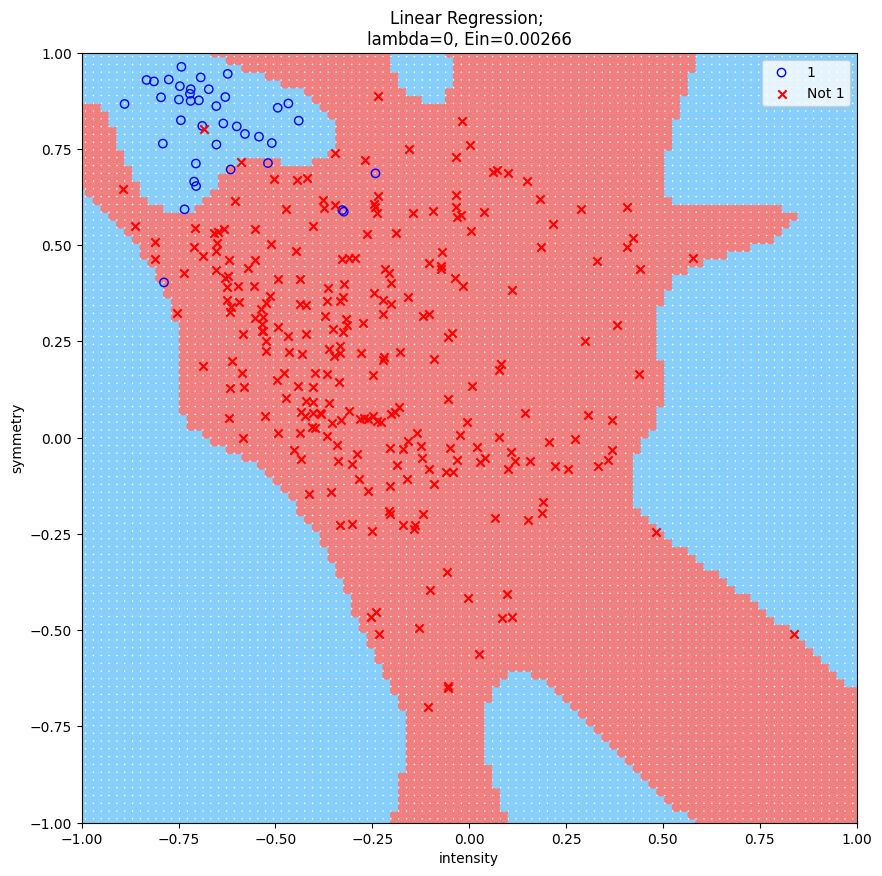

In [297]:
Ein = np.round(squaredError(w_reg, Z, y), 5)
plotNonLinearSeparator(w_reg, X, y, Q=Q,
                           title=f'Linear Regression; \nlambda={lamda}, Ein={Ein}')

In [298]:
lamda = 3
w_reg = linearRegressionRegularized(Z, y, lamda)

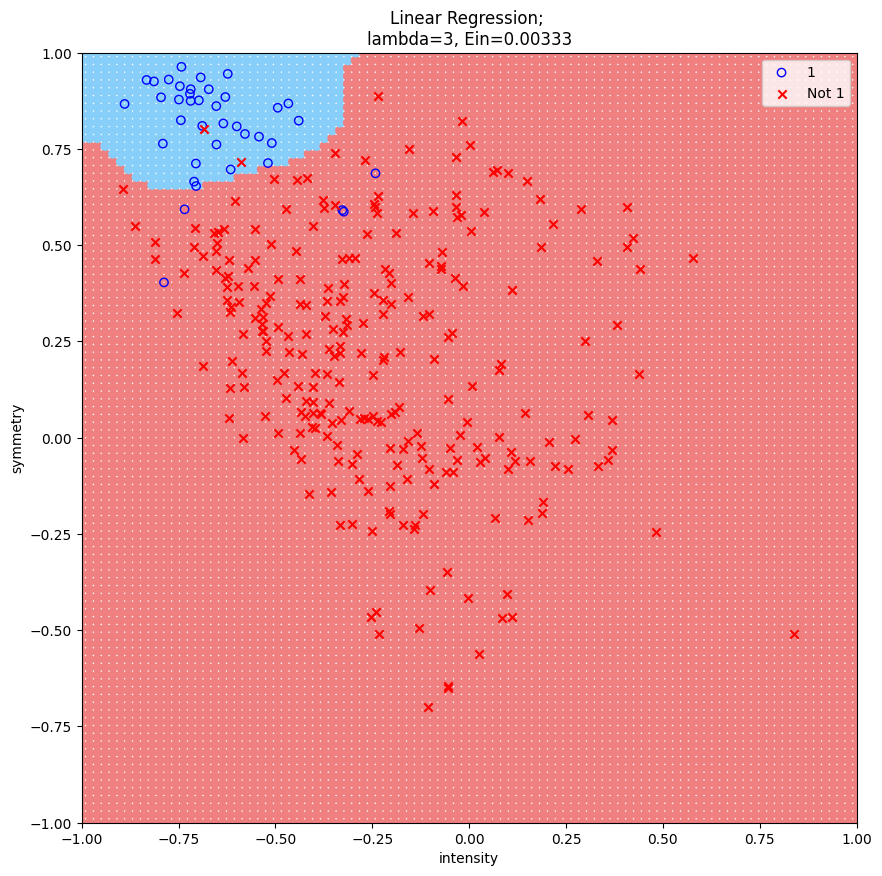

In [299]:
Ein = np.round(squaredError(w_reg, Z, y), 5)
plotNonLinearSeparator(w_reg, X, y, Q=Q,
                           title=f'Linear Regression; \nlambda={lamda}, Ein={Ein}')

In [300]:
def linearRegressionCVError(X, y, lamda):
    '''
    Implements the one-step algorithm for Linear Regression
    Input:
        X: A 2 dimensional N x d numpy array
           The i-th row X[i, :] contains features for the i-th example in the training set
           X[i, 0] = 1
           X[i, 1], ... X[i, d] have values of features
        y: A 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        lamda: a non-negative real number which controls the amount of regularization
               called lamda instead of lambda because python has an in-built lambda
    Output:
        Ecv: The leave one out cross validation error of linear regression with regularization parameter lamda on data X, y
    '''
    N, d = X.shape
    Ecv = 0
    for n in range(N):
        new_X = np.delete(X, n, axis = 0)
        new_y = np.delete(y, n, axis = 0)
        X_Trans = np.transpose(new_X)
        inverse_part = np.linalg.inv(X_Trans.dot(new_X) + lamda * np.eye(d))
        w = inverse_part.dot(X_Trans).dot(new_y)
        leftX = X[n, :]
        leftY = y[n, 0]
        predy = np.dot(leftX, w)
        sqError = (predy - leftY) * (predy - leftY)
        Ecv = Ecv + sqError
        Ecv = Ecv/N
    return Ecv

In [301]:
lamda = 0
Ecv = linearRegressionCVError(Z, y, lamda)
print(f'Linear Regression with Regularization with lambda={lamda}, Ecv = {Ecv}')

Linear Regression with Regularization with lambda=0, Ecv = [0.00034804]


Linear Regression with Regularization with lambda=0, Ecv = [0.00034804]
Linear Regression with Regularization with lambda=0.001, Ecv = [0.00023753]
Linear Regression with Regularization with lambda=0.01, Ecv = [0.00022179]
Linear Regression with Regularization with lambda=0.1, Ecv = [0.00023304]
Linear Regression with Regularization with lambda=1, Ecv = [0.00030425]
Linear Regression with Regularization with lambda=10, Ecv = [0.00049352]
Linear Regression with Regularization with lambda=25, Ecv = [0.0006216]
Linear Regression with Regularization with lambda=50, Ecv = [0.00075942]
Linear Regression with Regularization with lambda=75, Ecv = [0.0008576]
Linear Regression with Regularization with lambda=100, Ecv = [0.00093755]


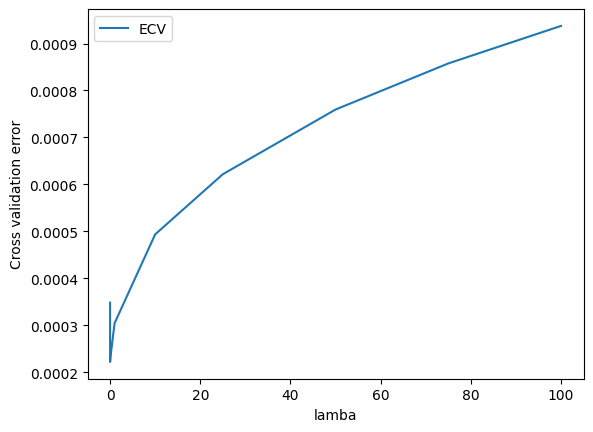

In [302]:
lamdas = [0, 0.001, 0.01, 0.1, 1, 10, 25, 50, 75, 100]
Ecvs = []
Eouts = []

for lamda in lamdas:
    Ecv = linearRegressionCVError(Z, y, lamda)
    print(f'Linear Regression with Regularization with lambda={lamda}, Ecv = {Ecv}')
    Ecvs.append(Ecv)
    w_reg = linearRegressionRegularized(Z, y, lamda)

plt.plot(lamdas, Ecvs, label = "ECV")
plt.xlabel('lamba')
plt.ylabel('Cross validation error')
plt.legend()
plt.show()

In [303]:
optlamda = lamdas[np.argmin(Ecvs)]

print(optlamda)

0.01


The best value of λ i.e. λ∗ =  0.01


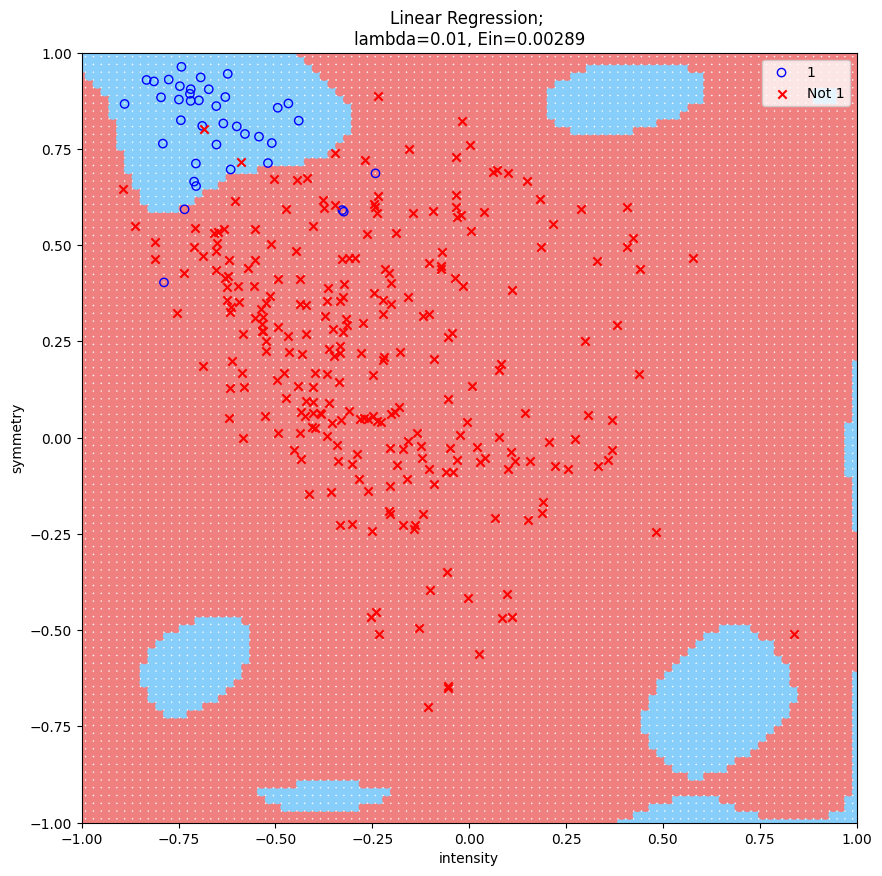

In [304]:
lamda_star = optlamda

print('The best value of λ i.e. λ∗ = ', lamda_star)
w_reg = linearRegressionRegularized(Z, y, lamda_star)

Ein = np.round(squaredError(w_reg, Z, y), 5)
plotNonLinearSeparator(w_reg, X, y, Q=Q,
                           title=f'Linear Regression; \nlambda={lamda_star}, Ein={Ein}')

In [305]:
import math
Eout_optimal = np.round(squaredError(w_reg, Ztest, ytest), 5)

# find Error bar N = 300 , dvc =2 ##test  , delta = 0.01
penalty =  np.sqrt((0.08/3)* np.log(4* (2 * 301)/ 0.01) / np.log(math.e) )
print("Penalty =", penalty)
Eout_estimated = Ein + penalty

print("Eout Actual =" ,Eout_optimal, " , Eout Estimated =" , Eout_estimated )

Penalty = 0.574844256992954
Eout Actual = 0.12033  , Eout Estimated = 0.577734256992954
